# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from mpl_toolkits.mplot3d import Axes3D

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv",delimiter=";")

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv",delimiter=";")

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print("General population demographics data file size : ",azdias.shape)
print("Feature summary file size : ",feat_info.shape)
azdias.head(10)

General population demographics data file size :  (891221, 85)
Feature summary file size :  (85, 4)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [4]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
def assess_missing_data(data):
    """
    Calculates the missing data and returns its proportion against the whole dataset. 
    """
    
    missing_data = data.isna().mean()
    missing_data = dict(zip(missing_data.index,missing_data.values))
    return missing_data

missing_data_before_preprocess = assess_missing_data(azdias)
missing_data_before_preprocess

{'AGER_TYP': 0.0,
 'ALTERSKATEGORIE_GROB': 0.0,
 'ANREDE_KZ': 0.0,
 'CJT_GESAMTTYP': 0.0054464605299920001,
 'FINANZ_MINIMALIST': 0.0,
 'FINANZ_SPARER': 0.0,
 'FINANZ_VORSORGER': 0.0,
 'FINANZ_ANLEGER': 0.0,
 'FINANZ_UNAUFFAELLIGER': 0.0,
 'FINANZ_HAUSBAUER': 0.0,
 'FINANZTYP': 0.0,
 'GEBURTSJAHR': 0.0,
 'GFK_URLAUBERTYP': 0.0054464605299920001,
 'GREEN_AVANTGARDE': 0.0,
 'HEALTH_TYP': 0.0,
 'LP_LEBENSPHASE_FEIN': 0.0054464605299920001,
 'LP_LEBENSPHASE_GROB': 0.0054464605299920001,
 'LP_FAMILIE_FEIN': 0.0054464605299920001,
 'LP_FAMILIE_GROB': 0.0054464605299920001,
 'LP_STATUS_FEIN': 0.0054464605299920001,
 'LP_STATUS_GROB': 0.0054464605299920001,
 'NATIONALITAET_KZ': 0.0,
 'PRAEGENDE_JUGENDJAHRE': 0.0,
 'RETOURTYP_BK_S': 0.0054464605299920001,
 'SEMIO_SOZ': 0.0,
 'SEMIO_FAM': 0.0,
 'SEMIO_REL': 0.0,
 'SEMIO_MAT': 0.0,
 'SEMIO_VERT': 0.0,
 'SEMIO_LUST': 0.0,
 'SEMIO_ERL': 0.0,
 'SEMIO_KULT': 0.0,
 'SEMIO_RAT': 0.0,
 'SEMIO_KRIT': 0.0,
 'SEMIO_DOM': 0.0,
 'SEMIO_KAEM': 0.0,
 'SEMIO_PF

### Analysis:

Lets confirm if existing missing data is captured properly.

In [6]:
azdias[azdias['CJT_GESAMTTYP'].isna()][:10]

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
138,-1,3,1,NaN,5,3,4,2,4,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,6.0,3.0
184,-1,2,2,NaN,2,2,4,2,2,3,...,3.0,2.0,1.0,1.0,1.0,4.0,4.0,3.0,5.0,1.0
255,-1,2,1,NaN,5,2,4,3,2,1,...,2.0,1.0,0.0,0.0,1.0,3.0,4.0,1.0,1.0,1.0
1020,-1,3,1,NaN,5,2,4,2,2,1,...,3.0,2.0,0.0,0.0,1.0,5.0,5.0,2.0,2.0,1.0
1044,-1,4,2,NaN,3,1,5,1,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0
1322,-1,1,1,NaN,4,2,2,4,5,1,...,3.0,2.0,0.0,0.0,1.0,2.0,3.0,3.0,3.0,3.0
1403,2,4,2,NaN,2,1,5,1,1,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,1.0,4.0,1.0
1488,1,4,2,NaN,2,1,5,3,1,5,...,0.0,2.0,3.0,2.0,4.0,2.0,1.0,5.0,5.0,5.0
1613,1,4,1,NaN,5,1,4,1,1,3,...,3.0,1.0,0.0,0.0,1.0,3.0,4.0,5.0,5.0,5.0
1621,-1,1,1,NaN,2,5,3,4,5,2,...,4.0,1.0,0.0,0.0,1.0,3.0,4.0,4.0,7.0,5.0


### Analysis:

Lets analyze the missing or unknown codes in Feature summary dataframe

In [7]:
for feature_name,missing_code in zip(feat_info['attribute'],feat_info['missing_or_unknown']):
    print(feature_name,missing_code)

AGER_TYP [-1,0]
ALTERSKATEGORIE_GROB [-1,0,9]
ANREDE_KZ [-1,0]
CJT_GESAMTTYP [0]
FINANZ_MINIMALIST [-1]
FINANZ_SPARER [-1]
FINANZ_VORSORGER [-1]
FINANZ_ANLEGER [-1]
FINANZ_UNAUFFAELLIGER [-1]
FINANZ_HAUSBAUER [-1]
FINANZTYP [-1]
GEBURTSJAHR [0]
GFK_URLAUBERTYP []
GREEN_AVANTGARDE []
HEALTH_TYP [-1,0]
LP_LEBENSPHASE_FEIN [0]
LP_LEBENSPHASE_GROB [0]
LP_FAMILIE_FEIN [0]
LP_FAMILIE_GROB [0]
LP_STATUS_FEIN [0]
LP_STATUS_GROB [0]
NATIONALITAET_KZ [-1,0]
PRAEGENDE_JUGENDJAHRE [-1,0]
RETOURTYP_BK_S [0]
SEMIO_SOZ [-1,9]
SEMIO_FAM [-1,9]
SEMIO_REL [-1,9]
SEMIO_MAT [-1,9]
SEMIO_VERT [-1,9]
SEMIO_LUST [-1,9]
SEMIO_ERL [-1,9]
SEMIO_KULT [-1,9]
SEMIO_RAT [-1,9]
SEMIO_KRIT [-1,9]
SEMIO_DOM [-1,9]
SEMIO_KAEM [-1,9]
SEMIO_PFLICHT [-1,9]
SEMIO_TRADV [-1,9]
SHOPPER_TYP [-1]
SOHO_KZ [-1]
TITEL_KZ [-1,0]
VERS_TYP [-1]
ZABEOTYP [-1,9]
ALTER_HH [0]
ANZ_PERSONEN []
ANZ_TITEL []
HH_EINKOMMEN_SCORE [-1,0]
KK_KUNDENTYP [-1]
W_KEIT_KIND_HH [-1,0]
WOHNDAUER_2008 [-1,0]
ANZ_HAUSHALTE_AKTIV [0]
ANZ_HH_TITEL []
GEBAE

### Analysis: 
Inaddition to numeric missing codes, there are few cases where the missing codes are alpha numeric. Lets analyze further so that it can be included in the functions which converts the missing codes to NaNs

In [8]:
azdias[azdias['CAMEO_DEUG_2015']=='X']['CAMEO_DEUG_2015'][:10]

2511     X
4569     X
9803     X
16700    X
16883    X
22386    X
28123    X
31618    X
32864    X
33666    X
Name: CAMEO_DEUG_2015, dtype: object

In [9]:
azdias['CAMEO_DEUG_2015'][2500:2515]

2500      4
2501      3
2502      4
2503      9
2504    NaN
2505      6
2506      6
2507    NaN
2508      4
2509      9
2510      9
2511      X
2512      9
2513      5
2514      9
Name: CAMEO_DEUG_2015, dtype: object

In [10]:
# Identify missing or unknown data values and convert them to NaNs.

def preprocess(val):
    """
    Replaces characters like [, ] and split the string using the delimiter: ','
    
    Output = Returns an array of string
    """
    val = val.replace('[','')
    val = val.replace(']','')
    val_arr = val.split(',')
    return val_arr

def to_number(code):
    """
    Converts the value to an integer if its a number else returns the value as such or NONE for empty string
    """
    code = code.lstrip()
    if code is '':
        return 'NONE'
    try:
        int(code)
    except ValueError:
        return code
    else:
        return int(code)
    
def contruct_replace_values(missing_code):
    """
    Contruct a dictionary using the iterables codes(it contains a list of missing codes) 
    and nan_values(it contains a list of np.nan values for each element in codes)
    """
    codes = list(map(to_number,preprocess(missing_code)))
    nan_values = list(np.nan for x in codes)
    return dict(zip(codes,nan_values))


#Loops over each rows of feat_info dataframe to convert Missing Value Codes to NaNs in general demographics dataframe: azdias 
for feature_name,missing_code in zip(feat_info['attribute'],feat_info['missing_or_unknown']):
    replace_values = contruct_replace_values(missing_code)
    
    #Skip the replace step if there is no missing or unknown code(s) mentioned in feat_info dataframe for the respective 'feature'
    if 'NONE' in replace_values:
        continue
        
    #Replace missing codes mentioned in each column of general demographics dataframe using the above dictionary 
    azdias[[feature_name]]=azdias[[feature_name]].replace(replace_values)

### Analysis:

Lets confirm if the missing codes are converted to NaNs

In [11]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [12]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
    
missing_data_after_preprocess1 = assess_missing_data(azdias)
missing_data_after_preprocess1

{'AGER_TYP': 0.76955435296071339,
 'ALTERSKATEGORIE_GROB': 0.0032326437550282143,
 'ANREDE_KZ': 0.0,
 'CJT_GESAMTTYP': 0.0054464605299920001,
 'FINANZ_MINIMALIST': 0.0,
 'FINANZ_SPARER': 0.0,
 'FINANZ_VORSORGER': 0.0,
 'FINANZ_ANLEGER': 0.0,
 'FINANZ_UNAUFFAELLIGER': 0.0,
 'FINANZ_HAUSBAUER': 0.0,
 'FINANZTYP': 0.0,
 'GEBURTSJAHR': 0.44020282286885071,
 'GFK_URLAUBERTYP': 0.0054464605299920001,
 'GREEN_AVANTGARDE': 0.0,
 'HEALTH_TYP': 0.12476815514894735,
 'LP_LEBENSPHASE_FEIN': 0.10954858559212585,
 'LP_LEBENSPHASE_GROB': 0.10611509378706292,
 'LP_FAMILIE_FEIN': 0.087286991666489011,
 'LP_FAMILIE_GROB': 0.087286991666489011,
 'LP_STATUS_FEIN': 0.0054464605299920001,
 'LP_STATUS_GROB': 0.0054464605299920001,
 'NATIONALITAET_KZ': 0.12153551139391913,
 'PRAEGENDE_JUGENDJAHRE': 0.12136608091595687,
 'RETOURTYP_BK_S': 0.0054464605299920001,
 'SEMIO_SOZ': 0.0,
 'SEMIO_FAM': 0.0,
 'SEMIO_REL': 0.0,
 'SEMIO_MAT': 0.0,
 'SEMIO_VERT': 0.0,
 'SEMIO_LUST': 0.0,
 'SEMIO_ERL': 0.0,
 'SEMIO_KULT': 0

### Analysis

Above cells displays the amount of missing data. Lets consider a column for further analysis. In the original dataset before preprocessing that is before converting missing codes to NaNs, the amount of missing data of TITEL_KZ column was 0.08 that is 8% whereas after converting missing codes to NaNs, it is 0.99 that is 99%. This is an Outlier column. Lets examine further to capture all the outlier columns in this dataset.

In [13]:
print(missing_data_before_preprocess['TITEL_KZ'])
print(missing_data_after_preprocess1['TITEL_KZ'])

0.0824700046341
0.997576358726


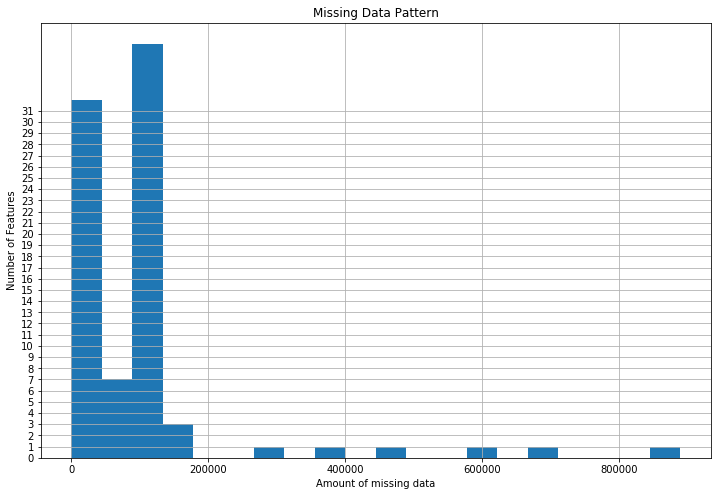

In [14]:
# Investigate patterns in the amount of missing data in each column.

def visualize_missing_data(data,axis,xlabel,ylabel,title):
    """
    Visualizes the amount of missing data in each row/column
    """
    missing_data_pattern = data.isna().sum(axis=axis)
    #missing_data_pattern = pd.DataFrame(list(zip(missing_data.index,missing_data)))
    #missing_data_pattern.columns=['Feature_Name','Missing_Data_Metric']
    missing_data_pattern.hist(figsize=(12,8),bins=20)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if axis == 0:
        plt.yticks(range(32))
    plt.title(title)
    
visualize_missing_data(azdias,0,"Amount of missing data","Number of Features","Missing Data Pattern")

### Analysis:

Per the above histogram, there are 6 outlier columns for which the amount of missing data is more than 20% of the total data. Lets confirm this data further in the below cell and analyze them further by referring the DataDictionary.

In [15]:
#Identify the outlier columns

outlier_cols=[]
for data_metric in missing_data_after_preprocess1.items():
    if data_metric[1] > 0.20:
        print(data_metric)
        outlier_cols.append(data_metric[0])
print("Outlier column names: ", outlier_cols)

('AGER_TYP', 0.76955435296071339)
('GEBURTSJAHR', 0.44020282286885071)
('TITEL_KZ', 0.99757635872583794)
('ALTER_HH', 0.34813699407890975)
('KK_KUNDENTYP', 0.65596748730112953)
('KBA05_BAUMAX', 0.53468668265222652)
Outlier column names:  ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


Size of azdias dataframe after dropping outlier columns:  (891221, 79)


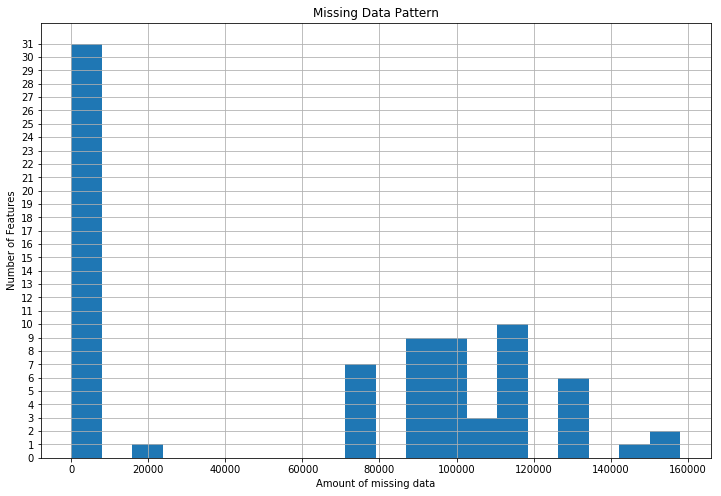

In [16]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

azdias.drop(columns=outlier_cols,axis=1,inplace=True)
print("Size of azdias dataframe after dropping outlier columns: ", azdias.shape)
visualize_missing_data(azdias,0,"Amount of missing data","Number of Features","Missing Data Pattern")

### Analysis:
Lets confirm if outlier columns are removed.

In [17]:
missing_data_after_preprocess2 = assess_missing_data(azdias)
missing_data_after_preprocess2

{'ALTERSKATEGORIE_GROB': 0.0032326437550282143,
 'ANREDE_KZ': 0.0,
 'CJT_GESAMTTYP': 0.0054464605299920001,
 'FINANZ_MINIMALIST': 0.0,
 'FINANZ_SPARER': 0.0,
 'FINANZ_VORSORGER': 0.0,
 'FINANZ_ANLEGER': 0.0,
 'FINANZ_UNAUFFAELLIGER': 0.0,
 'FINANZ_HAUSBAUER': 0.0,
 'FINANZTYP': 0.0,
 'GFK_URLAUBERTYP': 0.0054464605299920001,
 'GREEN_AVANTGARDE': 0.0,
 'HEALTH_TYP': 0.12476815514894735,
 'LP_LEBENSPHASE_FEIN': 0.10954858559212585,
 'LP_LEBENSPHASE_GROB': 0.10611509378706292,
 'LP_FAMILIE_FEIN': 0.087286991666489011,
 'LP_FAMILIE_GROB': 0.087286991666489011,
 'LP_STATUS_FEIN': 0.0054464605299920001,
 'LP_STATUS_GROB': 0.0054464605299920001,
 'NATIONALITAET_KZ': 0.12153551139391913,
 'PRAEGENDE_JUGENDJAHRE': 0.12136608091595687,
 'RETOURTYP_BK_S': 0.0054464605299920001,
 'SEMIO_SOZ': 0.0,
 'SEMIO_FAM': 0.0,
 'SEMIO_REL': 0.0,
 'SEMIO_MAT': 0.0,
 'SEMIO_VERT': 0.0,
 'SEMIO_LUST': 0.0,
 'SEMIO_ERL': 0.0,
 'SEMIO_KULT': 0.0,
 'SEMIO_RAT': 0.0,
 'SEMIO_KRIT': 0.0,
 'SEMIO_DOM': 0.0,
 'SEMIO_K

#### Discussion 1.1.2: Assess Missing Data in Each Column

Out of 85 features, only 31 features doesn't have any data loss. Out of 54 remaining features, below are the ones that has more than 20% of data loss. Lets drop these outlier columns.

    ('AGER_TYP', 0.76955435296071339)
    ('GEBURTSJAHR', 0.44020282286885071)
    ('TITEL_KZ', 0.99757635872583794)
    ('ALTER_HH', 0.34813699407890975)
    ('KK_KUNDENTYP', 0.65596748730112953)
    ('KBA05_BAUMAX', 0.53468668265222652)

##### Observed below patterns in the missing values:

There are certain columns which starts with below keys have same amount of missing data since they are captures related data.

* 'KBA05_' with 0.14959701353536328 data loss.
* 'PLZ8_' with  0.13073637178657146 data loss.
* 'CAMEO_' with  0.11147852216229195 data loss.
* 'SEMIO_' - no data loss.
* 'FINANZ_' - no data loss.
* 'LP_FAMILIE_' with 0.087286991666489011 data loss.
* 'LP_STATUS_' with 0.0054464605299920001 data loss.

 
##### Below are the columns removed from the dataset: 
    'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

First 10 missing data rows 0    43
1     0
2     0
3     7
4     0
5     0
6     0
7     0
8     0
9     0
dtype: int64


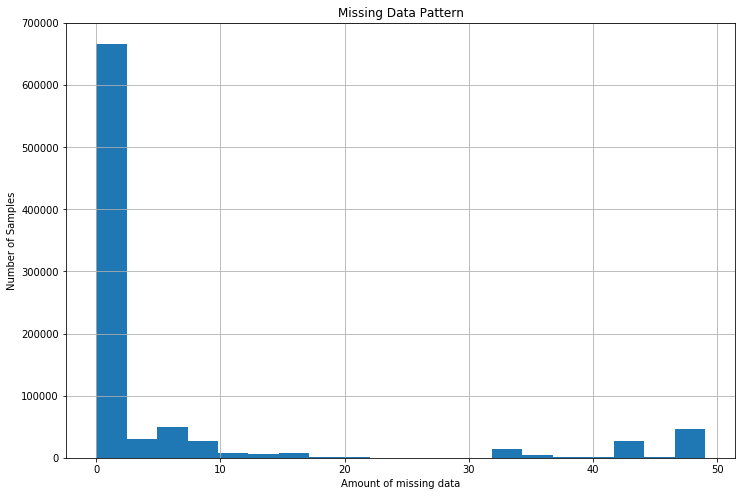

In [18]:
# How much data is missing in each row of the dataset?

missing_data_rows = azdias.isna().sum(axis=1)
print("First 10 missing data rows",missing_data_rows[0:10])
visualize_missing_data(azdias,1,"Amount of missing data","Number of Samples","Missing Data Pattern")

### Analysis:

Lets use 'sum()' function instead of 'mean()' to calculate the amount of missing data in each row of the dataset. Per the above figure, we can see that there are two distinct groups where one has fewer number of missing data and other has more number of missing data. Lets analyze further to find an optimal value for the threshold.

In [19]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

def divide_dataset(threshold,data):
    """
    Divides the dataset based on the threshold
    """
    dataset_1 = data[data.isna().sum(axis=1) <= threshold]
    dataset_2 = data[data.isna().sum(axis=1) > threshold]
    return dataset_1, dataset_2

def calculate_ratio(threshold,ori_dataset_len,dataset_1,dataset_2):
    ds1_col_ratio = threshold/dataset_1.shape[1]*100
    ds2_col_ratio = 100-threshold/dataset_1.shape[1]*100
    ds1_datapoints_percent = len(dataset_1)/ori_dataset_len*100
    ds2_datapoints_percent = len(dataset_2)/ori_dataset_len*100
    return ds1_col_ratio,ds2_col_ratio,ds1_datapoints_percent,ds2_datapoints_percent

#### Lets determine data loss and percentile of data points for a range of thresholds. 
#### Add all the collected ratios to its respective list which is used for plotting to 
#### find an optimal threshold value in the cells below.
threshold_range = 30
ori_dataset_len = len(azdias)
dataset_1_list = []
dataset_2_list = []
for threshold in range(15,threshold_range+1):       

    #Divide the dataset
    dataset_1,dataset_2 = divide_dataset(threshold,azdias)
    
    #Calculate the ratios
    ds1_col_ratio,ds2_col_ratio,ds1_datapoints_percent,ds2_datapoints_percent = calculate_ratio(threshold,ori_dataset_len,dataset_1,dataset_2)
    
    #Append the ratios and threhsold to its respective list for plotting
    dataset_1_list.append([threshold,ds1_col_ratio,ds1_datapoints_percent])    
    dataset_2_list.append([threshold,ds2_col_ratio,ds2_datapoints_percent])

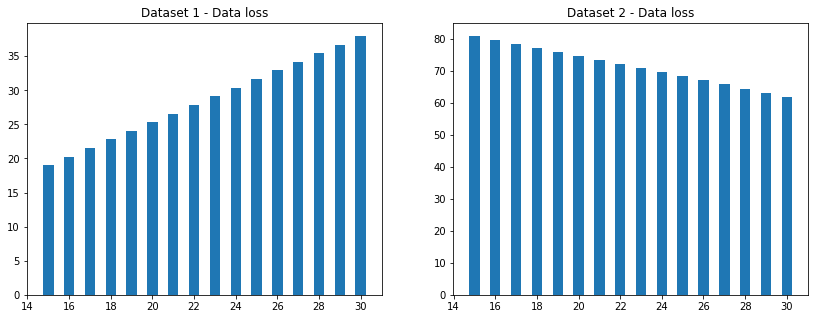

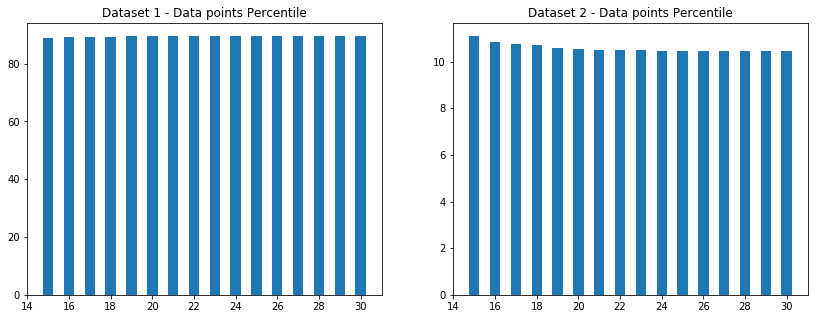

In [20]:
def compare_plot_by_row(x1,x2,y1,y2,desc):
    """
    Compares the plots of both the datasets
    """
    width = 0.5
    plt.figure(figsize=(14,5))
    plt.grid(True)

    plt.subplot(1,2,1)
    plt.title("Dataset 1 - {}".format(desc))    
    plt.bar(x1, y1, width, align='center')
    plt.subplot(1,2,2)
    plt.title("Dataset 2 - {}".format(desc))
    plt.bar(x2, y2, width, align='center')


            
#### Compare the plots of data loss and percentile of data points for the threshold range for both the datasets 
#### and pick an optimal threshold value.
#Unzip the data
ds1_thresh,ds1_dataloss,ds1_percent = zip(*dataset_1_list)
ds2_thresh,ds2_dataloss,ds2_percent = zip(*dataset_2_list)

#Plot the Data loss and Data points Percentile for various thresholds for both Datasets.
compare_plot_by_row(ds1_thresh,ds2_thresh,ds1_dataloss,ds2_dataloss,"Data loss")
compare_plot_by_row(ds1_thresh,ds2_thresh,ds1_percent,ds2_percent,"Data points Percentile")

In [21]:
####Lets divide the dataset into two subsets using the finalized threshold.

#Print Max and Mix values of data loss and data points percentile and its respective differences.
print("Dataset 1")
print("Difference between max({:.2f}%) and min({:.2f}%) data loss: {:.2f}% "\
      .format(max(ds1_dataloss),min(ds1_dataloss),(max(ds1_dataloss)-min(ds1_dataloss))))
print("Difference between max({:.2f}%) and min({:.2f}%) percentile of data points: {:.2f}%"\
      .format(max(ds1_percent),min(ds1_percent),(max(ds1_percent)-min(ds1_percent))))
print("\n")

#Set the threshold to the optimal value
threshold=ds1_thresh[ds1_dataloss.index(min(ds1_dataloss))]

#Divide the dataset using the finalized threshold.
dataset_1,dataset_2 = divide_dataset(threshold,azdias)

#Calculate the ratios using the finalized threshold.
ds1_col_ratio,ds2_col_ratio,ds1_datapoints_percent,ds2_datapoints_percent = calculate_ratio(threshold,ori_dataset_len,dataset_1,dataset_2)

#Print data metrics
print("Optimal Threshold value: ", threshold)
print("General demographic dataset \'azdias\' can be divided into two subsets with threshold {}.".format(threshold))
print("Dataset 1 Data loss: {:.2f}%. Percent of data points in \'azdias\' that are below the threshold: {:.2f}%"\
      .format(ds1_col_ratio,ds1_datapoints_percent))
print("Dataset 2 Data loss: {:.2f}%. Percent of data points in \'azdias\' that are below the threshold: {:.2f}%"\
      .format(ds2_col_ratio,ds2_datapoints_percent))

Dataset 1
Difference between max(37.97%) and min(18.99%) data loss: 18.99% 
Difference between max(89.55%) and min(88.90%) percentile of data points: 0.65%


Optimal Threshold value:  15
General demographic dataset 'azdias' can be divided into two subsets with threshold 15.
Dataset 1 Data loss: 18.99%. Percent of data points in 'azdias' that are below the threshold: 88.90%
Dataset 2 Data loss: 81.01%. Percent of data points in 'azdias' that are below the threshold: 11.10%


In [22]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

column_names = ['ANREDE_KZ','FINANZ_MINIMALIST','GREEN_AVANTGARDE','SEMIO_FAM','OST_WEST_KZ']
print("Dataset 1")
missing_dataset_1 = assess_missing_data(dataset_1)
for col in column_names:
    print("{}: {}".format(col,missing_dataset_1[col]))
     
print("\nDataset 2")
missing_dataset_2 = assess_missing_data(dataset_2)
for col in column_names:
    print("{}: {}".format(col,missing_dataset_1[col]))

Dataset 1
ANREDE_KZ: 0.0
FINANZ_MINIMALIST: 0.0
GREEN_AVANTGARDE: 0.0
SEMIO_FAM: 0.0
OST_WEST_KZ: 0.0

Dataset 2
ANREDE_KZ: 0.0
FINANZ_MINIMALIST: 0.0
GREEN_AVANTGARDE: 0.0
SEMIO_FAM: 0.0
OST_WEST_KZ: 0.0


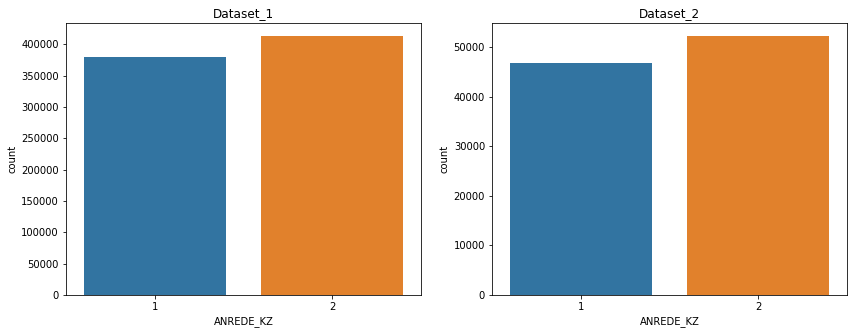

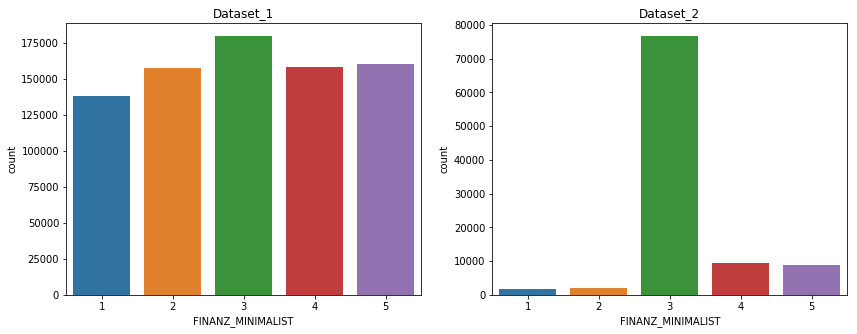

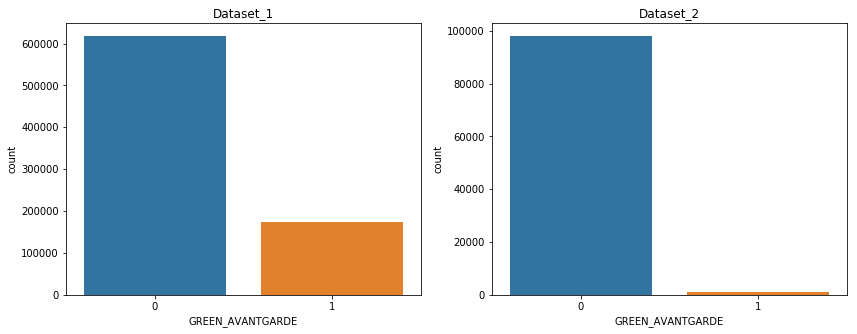

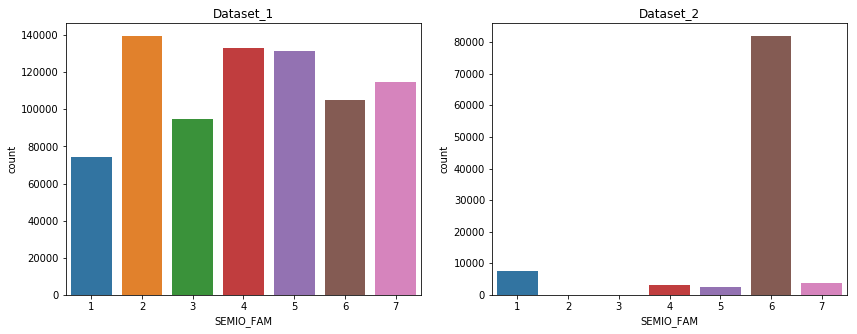

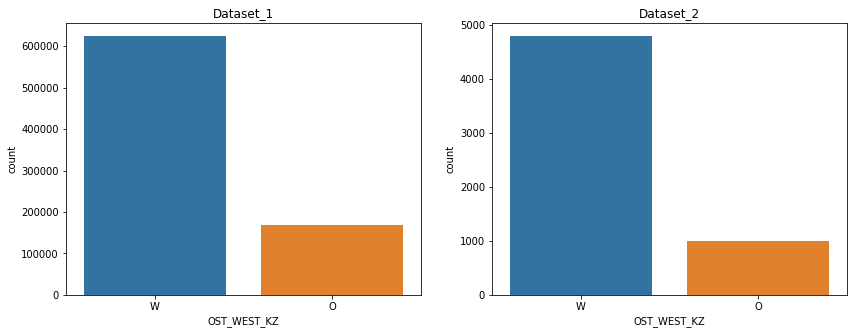

In [23]:
def compare_plot_by_column(col):
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.title("Dataset_1")
    sns.countplot(x=col,data=dataset_1)
    plt.subplot(1,2,2)
    plt.title("Dataset_2")
    sns.countplot(x=col,data=dataset_2)
    
column_names = ['ANREDE_KZ','FINANZ_MINIMALIST','GREEN_AVANTGARDE','SEMIO_FAM','OST_WEST_KZ']
for col in column_names:
    compare_plot_by_column(col)

#### Discussion 1.1.3: Assess Missing Data in Each Row


After comparing the minimum and maximun data loss and the datapoints percentile for various thresholds(from 15 till 30), we can conclude that if we divide the dataset using the threshold 15, the data loss would be minimal that is 18.99% and the percentage of datapoints that are below the thresold would be 88.90% whereas if we set the threshold as 30 then the data loss would be 37.97% which is 18.99%(twice the loss) more than its corresponding minimum value whereas the percentage of datapoints would be 89.55% which is just 0.65% more than its minimal value. Hence threshold 15 is the optimal value for datapoints retention as well data loss.

On comparing both the datasets for the following columns, we can notice that the dataset2 which has 81.01% data loss looks qualitatively similiar to the data in the dataset 1 columns that has no missing values. Hence dropping those dataset 2 points from the analysis won't present a major issue.

#### Columns considered for comparison

'ANREDE_KZ','FINANZ_MINIMALIST','GREEN_AVANTGARDE','SEMIO_FAM','OST_WEST_KZ'

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [24]:
# How many features are there of each data type?
feat_info.groupby('type').count()


,attribute,information_level,missing_or_unknown
type,,,
categorical,21,21,21
interval,1,1,1
mixed,7,7,7
numeric,7,7,7
ordinal,49,49,49


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [25]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

categorical_names= feat_info[feat_info['type']=='categorical']['attribute'].values
print("Categorical variables:")
print("---------------------")
print(categorical_names)
      
categorical_names = [name for name in categorical_names if name in dataset_1]
print("\nAfter comparing with the dataset columns:")
print("------------------------------------------")
print(categorical_names)
      
print("\nUnique values in each categorical column:")
print("------------------------------------------")
print(dataset_1[categorical_names].nunique())
initial_categorical_names = categorical_names

Categorical variables:
---------------------
['AGER_TYP' 'ANREDE_KZ' 'CJT_GESAMTTYP' 'FINANZTYP' 'GFK_URLAUBERTYP'
 'GREEN_AVANTGARDE' 'LP_FAMILIE_FEIN' 'LP_FAMILIE_GROB' 'LP_STATUS_FEIN'
 'LP_STATUS_GROB' 'NATIONALITAET_KZ' 'SHOPPER_TYP' 'SOHO_KZ' 'TITEL_KZ'
 'VERS_TYP' 'ZABEOTYP' 'KK_KUNDENTYP' 'GEBAEUDETYP' 'OST_WEST_KZ'
 'CAMEO_DEUG_2015' 'CAMEO_DEU_2015']

After comparing with the dataset columns:
------------------------------------------
['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']

Unique values in each categorical column:
------------------------------------------
ANREDE_KZ            2
CJT_GESAMTTYP        6
FINANZTYP            6
GFK_URLAUBERTYP     12
GREEN_AVANTGARDE     2
LP_FAMILIE_FEIN     11
LP_FAMILIE_GROB      5
LP_STATUS_

In [26]:
dataset_1[categorical_names].head()

,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
1,2,5.0,1,10.0,0,5.0,3.0,2.0,1.0,1.0,3.0,1.0,2.0,5,8.0,W,8,8A
2,2,3.0,1,10.0,1,1.0,1.0,3.0,2.0,1.0,2.0,0.0,1.0,5,1.0,W,4,4C
3,2,2.0,6,1.0,0,NaN,NaN,9.0,4.0,1.0,1.0,0.0,1.0,3,1.0,W,2,2A
4,1,5.0,5,5.0,0,10.0,5.0,3.0,2.0,1.0,2.0,0.0,2.0,4,1.0,W,6,6B
5,2,2.0,2,1.0,0,1.0,1.0,4.0,2.0,1.0,0.0,0.0,2.0,4,1.0,W,8,8C


Lets check for NaNs in multi-level categorical features.

In [27]:
print(dataset_1.shape)
names = dataset_1[categorical_names].isna().sum()
print(names)

(792287, 79)
ANREDE_KZ               0
CJT_GESAMTTYP        4368
FINANZTYP               0
GFK_URLAUBERTYP      4368
GREEN_AVANTGARDE        0
LP_FAMILIE_FEIN     30511
LP_FAMILIE_GROB     30511
LP_STATUS_FEIN       4368
LP_STATUS_GROB       4368
NATIONALITAET_KZ    33115
SHOPPER_TYP         35855
SOHO_KZ                 0
VERS_TYP            35855
ZABEOTYP                0
GEBAEUDETYP             0
OST_WEST_KZ             0
CAMEO_DEUG_2015      4316
CAMEO_DEU_2015       4316
dtype: int64


### Analysis:
On considering all the multi class categoricals, all rows that are missing datas needs to be removed for re-encoding. Since removing missing datas removes 10% of the data points from the dataset, lets consider the features with no missing value, re-encode them for our analysis and drop the rest of the multi-level categoricals to retain datapoints.

In [28]:
cat_names = [ind for ind,name in zip(names.index,names.values) if name == 0]
print("Categoricals without missing values:\n",cat_names)
remove_cat_names = [ind for ind,name in zip(names.index,names.values) if name > 0]
print("\nCategoricals with missing values:\n",remove_cat_names)

Categoricals without missing values:
 ['ANREDE_KZ', 'FINANZTYP', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ']

Categoricals with missing values:
 ['CJT_GESAMTTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [29]:
# Re-encode categorical variable(s) to be kept in the analysis.

def onehotencoding(dataset,cat_names):
    """
    One-Hot Encoding
    """
    cat_columns_idx = [dataset.columns.get_loc(col) for col in cat_names]
    onehotencoder = OneHotEncoder(categorical_features=cat_columns_idx,sparse=False, handle_unknown="ignore")
    subset_cat_df = pd.DataFrame(data=onehotencoder.fit_transform(dataset))  
    return subset_cat_df

def drop_cols(dataset,names,desc):
    """
    Drops columns in the given dataset and prints the size of the dataset before and after the drop.
    """
    print("\n")
    print("Size of the dataset before dropping {}: {} ".format(desc,dataset.shape))
    dataset.drop(columns=names,axis=1,inplace=True)
    print("Size of the dataset after dropping {}: {}".format(desc,dataset.shape))
    print("Column(s) that is/are removed: {}".format(names))
    return dataset



#Lets remove the multi-level categorical columns that are missing values before re-encode
dataset_1 = drop_cols(dataset_1,remove_cat_names,"multi-level categoricals")

#Re-encode OST_WEST_KZ values as numbers
categorical_df = pd.get_dummies(dataset_1['OST_WEST_KZ'], prefix=['OST_WEST_KZ_col'])
dataset_1 = drop_cols(dataset_1,'OST_WEST_KZ',"OST_WEST_KZ")
cat_names.remove('OST_WEST_KZ')

### OneHotEncoding
subset_cat_df=onehotencoding(dataset_1[cat_names],cat_names)

#Lets remove the columns which are re-encoded before joining the re-encoded datasets. 
dataset_1 = drop_cols(dataset_1,cat_names,"re-encoded columns")

#Join re-encode datas to dataset_1 and create a new dataframe.
dataset_1 = dataset_1.join(categorical_df)
encoded_dataset = dataset_1.join(subset_cat_df)
print("\nSize of the dataset after Re-encoding: ",encoded_dataset.shape)



Size of the dataset before dropping multi-level categoricals: (792287, 79) 


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Size of the dataset after dropping multi-level categoricals: (792287, 68)
Column(s) that is/are removed: ['CJT_GESAMTTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


Size of the dataset before dropping OST_WEST_KZ: (792287, 68) 
Size of the dataset after dropping OST_WEST_KZ: (792287, 67)
Column(s) that is/are removed: OST_WEST_KZ


Size of the dataset before dropping re-encoded columns: (792287, 67) 
Size of the dataset after dropping re-encoded columns: (792287, 61)
Column(s) that is/are removed: ['ANREDE_KZ', 'FINANZTYP', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'ZABEOTYP', 'GEBAEUDETYP']

Size of the dataset after Re-encoding:  (792287, 88)


#### Discussion 1.2.1: Re-Encode Categorical Features

On considering all the multi class categoricals, all rows that are missing datas was removed for re-encoding. Since removing missing data from these multi class categoricals further drops 10% of the data points from the dataset_1(which has 88.90% of the data after assessing missing data in each row and column), the features without any missing value were considered for re-encoding and dropped the rest of the multi-level categoricals to retain datapoints.

###### Multi-level categoricals that were removed: 
    'CJT_GESAMTTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'

###### Re-encoded columns:
    'OST_WEST_KZ','ANREDE_KZ', 'FINANZTYP', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'ZABEOTYP', 'GEBAEUDETYP'
    
Size of the dataset after Re-encoding:  (792287, 88)

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [30]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

def engineer_columns(encoded_dataset,old_column,new_column,data_dict):
    """
    Engineer columns based on the information provided in a column
    """
    data_df = encoded_dataset[[old_column]]
    data_df.columns = [new_column]
    data_df.replace(to_replace=data_dict,inplace=True)
    encoded_dataset = encoded_dataset.join(data_df)
    return encoded_dataset
    
def generate_praegende_cols(encoded_dataset):
    """
    Generates engineered columns based on the information provided in the column: PRAEGENDE_JUGENDJAHRE
    """
    # 40s = 1, 50s = 2, 60s = 3, 70s = 4, 80s = 5, 90s = 6    
    decade_dict = {1.0:1, 2.0:1, 3.0:2, 4.0:2, 5.0:3, 6.0:3, 7.0:3, 8.0:4, 9.0:4, 10.0:5, 11.0:5, 12.0:5, \
                   13.0:5, 14.0:6, 15.0:6}
    # Mainstream = 1, Avantgarde = 2
    movement_dict = {1.0:1, 2.0:2, 3.0:1, 4.0:2, 5.0:1, 6.0:2, 7.0:2, 8.0:1, 9.0:2, 10.0:1, 11.0:2, \
                     12.0:1, 13.0:2, 14.0:1, 15.0:2}
    # EAST = 1, WEST = 2,EAST_WEST = 3
    nation_dict = {1.0:3, 2.0:3, 3.0:3, 4.0:3, 5.0:3, 6.0:2, 7.0:1, 8.0:3, 9.0:3, 10.0:2, 11.0:2, 12.0:1, \
                   13.0:1, 14.0:3, 15.0:3}
    engineered_col_names = ['DECADE','MOVEMENT','NATION']
    data_dicts = {0:decade_dict,1:movement_dict, 2:nation_dict}

    for ind, new_column in enumerate(engineered_col_names):
        encoded_dataset = engineer_columns(encoded_dataset,'PRAEGENDE_JUGENDJAHRE',new_column,data_dicts[ind])
    
    return encoded_dataset


encoded_dataset = generate_praegende_cols(encoded_dataset)

#Confirm the data
encoded_dataset[['DECADE','MOVEMENT','NATION']].head()

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3798: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


,DECADE,MOVEMENT,NATION
1,6.0,1.0,3.0
2,6.0,2.0,3.0
3,4.0,1.0,3.0
4,4.0,1.0,3.0
5,2.0,1.0,3.0


In [31]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

def generate_cameo_cols(encoded_dataset):
    """
    Generates engineered columns based on the information provided in the column: CAMEO_INTL_2015
    """
    wealth_dict = {11:1, 12:1, 13:1, 14:1, 15:1, 21:2, 22:2, 23:2, 24:2, 25:2, \
                   31:3, 32:3, 33:3, 34:3, 35:3, 41:4, 42:4, 43:4, 44:4, 45:4, \
                   51:5, 52:5, 53:5, 54:5, 55:5}
    lifestage_dict = {11:1, 12:2, 13:3, 14:4, 15:5, 21:1, 22:2, 23:3, 24:4, 25:5, \
                      31:1, 32:2, 33:3, 34:4, 35:5, 41:1, 42:2, 43:3, 44:4, 45:5, \
                      51:1, 52:2, 53:3, 54:4, 55:5}

    encoded_dataset.CAMEO_INTL_2015.fillna(value=0,inplace=True)
    encoded_dataset['CAMEO_INTL_2015'] = encoded_dataset['CAMEO_INTL_2015'].astype(str).astype(int)
    encoded_dataset = engineer_columns(encoded_dataset,'CAMEO_INTL_2015',"WEALTH",wealth_dict)
    encoded_dataset = engineer_columns(encoded_dataset,'CAMEO_INTL_2015',"LIFESTAGE",lifestage_dict)
    
    return encoded_dataset

encoded_dataset = generate_cameo_cols(encoded_dataset)

#Confirm the data
encoded_dataset[['WEALTH','LIFESTAGE']].head()

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3798: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


,WEALTH,LIFESTAGE
1,5,1
2,2,4
3,1,2
4,4,3
5,5,4


In [32]:
#Features: PRAEGENDE_JUGENDJAHRE, CAMEO_INTL_2015 are engineered into 3 new features and 2 new features respectively.
#Lets drop PRAEGENDE_JUGENDJAHRE, CAMEO_INTL_2015 features along with rest of the mixed type features

mixed_names= list(feat_info[feat_info['type']=='mixed']['attribute'].values)
#This column was removed earlier because it was one of the outlier columns.
mixed_names.remove('KBA05_BAUMAX')
print("Mixed type features:")
print("-------------------")
print(mixed_names)


encoded_dataset = drop_cols(encoded_dataset,mixed_names,"Mixed type features")

Mixed type features:
-------------------
['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']


Size of the dataset before dropping Mixed type features: (792287, 93) 
Size of the dataset after dropping Mixed type features: (792287, 87)
Column(s) that is/are removed: ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']


#### Discussion 1.2.2: Engineer Mixed-Type Features

As recommended, engineered two mixed type features: PRAEGENDE_JUGENDJAHRE, CAMEO_INTL_2015 and dropped the rest of the mixed type features. These two mixed type featured were engineered using dictionaries.

##### Mixed type featured that were removed:
    'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX'

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [33]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

#Re-engineering tasks were completed in the above cells.


In [34]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

#Dataframe contains only numeric, interval, ordinal type, encoded and engineered columns. 
#Rest of the categorical columns with missing data and mixed type features(including the columns which were used to generate
#engineerd columns) were dropped in earlier steps. Lets check the columns for our confirmation.

encoded_dataset.columns

Index([ 'ALTERSKATEGORIE_GROB',     'FINANZ_MINIMALIST',
               'FINANZ_SPARER',      'FINANZ_VORSORGER',
              'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER',
            'FINANZ_HAUSBAUER',            'HEALTH_TYP',
              'RETOURTYP_BK_S',             'SEMIO_SOZ',
                   'SEMIO_FAM',             'SEMIO_REL',
                   'SEMIO_MAT',            'SEMIO_VERT',
                  'SEMIO_LUST',             'SEMIO_ERL',
                  'SEMIO_KULT',             'SEMIO_RAT',
                  'SEMIO_KRIT',             'SEMIO_DOM',
                  'SEMIO_KAEM',         'SEMIO_PFLICHT',
                 'SEMIO_TRADV',          'ANZ_PERSONEN',
                   'ANZ_TITEL',    'HH_EINKOMMEN_SCORE',
              'W_KEIT_KIND_HH',        'WOHNDAUER_2008',
         'ANZ_HAUSHALTE_AKTIV',          'ANZ_HH_TITEL',
                 'KONSUMNAEHE',      'MIN_GEBAEUDEJAHR',
                 'KBA05_ANTG1',           'KBA05_ANTG2',
                 'KBA05_ANTG3',

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [35]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    #Loops over each rows of feat_info dataframe to convert Missing Value Codes to NaNs in general demographics dataframe: azdias 
    for feature_name,missing_code in zip(feat_info['attribute'],feat_info['missing_or_unknown']):
        replace_values = contruct_replace_values(missing_code)
    
        #Skip the replace step if there is no missing or unknown code(s) mentioned in feat_info dataframe for the respective 'feature'
        if 'NONE' in replace_values:
            continue

        #Replace missing codes mentioned in each column of dataframe using the above dictionary 
        df[[feature_name]] = df[[feature_name]].replace(replace_values)
    
    # remove selected columns and rows, ...    
    print("Outlier columns: ", outlier_cols)
    df.drop(columns=outlier_cols,axis=1,inplace=True) # Remove the outlier columns from the dataset.
    # divide the dataset using threshold 15 to remove outlier rows.
    dataset_1,dataset_2 = divide_dataset(15,df)
    
    # select, re-encode, and engineer column values.
    #Lets remove the multi-level categorical columns that are missing values before re-encode
    dataset_1 = drop_cols(dataset_1,remove_cat_names,"multi-level categoricals")

    #Re-encode OST_WEST_KZ values as numbers
    categorical_df = pd.get_dummies(dataset_1['OST_WEST_KZ'], prefix=['OST_WEST_KZ_col'])
    dataset_1 = drop_cols(dataset_1,'OST_WEST_KZ',"OST_WEST_KZ")
    if 'OST_WEST_KZ' in cat_names:
        cat_names.remove('OST_WEST_KZ')

    ### OneHotEncoding
    subset_cat_df=onehotencoding(dataset_1[cat_names],cat_names)

    #Lets remove the columns which are re-encoded before joining the re-encoded datasets. 
    dataset_1 = drop_cols(dataset_1,cat_names,"re-encoded columns")

    #Join re-encode datas to dataset_1 and create a new dataframe.
    dataset_1 = dataset_1.join(categorical_df)
    encoded_dataset = dataset_1.join(subset_cat_df)
    print("\nSize of the dataset after Re-encoding: ",encoded_dataset.shape)
    
    #Engineer columns: PRAEGENDE_JUGENDJAHRE, CAMEO_INTL_2015
    encoded_dataset = generate_praegende_cols(encoded_dataset)
    encoded_dataset = generate_cameo_cols(encoded_dataset)
    
    #Features: PRAEGENDE_JUGENDJAHRE, CAMEO_INTL_2015 are engineered into 3 new features and 2 new features respectively.
    #Lets drop these two engineered features along with rest of the mixed type features
    mixed_names= list(feat_info[feat_info['type']=='mixed']['attribute'].values)
    
    #This column was removed earlier because it was one of the outlier columns.
    mixed_names.remove('KBA05_BAUMAX')
    
    print("Mixed type features:")
    print(mixed_names)


    encoded_dataset = drop_cols(encoded_dataset,mixed_names,"Mixed type features")
    
    # Return the cleaned dataframe.
    return encoded_dataset
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [36]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp_data = imp.fit_transform(encoded_dataset)

In [37]:
# Apply feature scaling to the general population demographics data.

std = StandardScaler()
std_data = std.fit_transform(imp_data)

### Discussion 2.1: Apply Feature Scaling

Since dropping NaNs will reduce the percentile of data points from the original dataset to 62.42% which is 26.48% less than the earlier one which is 88.90% data rentention. Lets use Imputer to replace missing values instead of dropping it and standardize the dataset for further processing.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [38]:
# Apply PCA to the data.

def do_pca(comp,data):
    pca = PCA(comp)
    final_dataset_pca = pca.fit_transform(data)
    return pca, final_dataset_pca
    

explained_variance = []
for n_comps in range(2,87):
    pca = PCA(n_comps)
    final_dataset_pca = pca.fit_transform(std_data)
    cumulative_variance = pca.explained_variance_ratio_.sum()
    explained_variance.append(cumulative_variance)

In [39]:
explained_variance[36:45]

[0.84606806589156847,
 0.85483097585991097,
 0.86286223790390371,
 0.87096841539863123,
 0.87839960146758211,
 0.88468449254960591,
 0.89067015519741166,
 0.89639123911542917,
 0.90203051052560723]

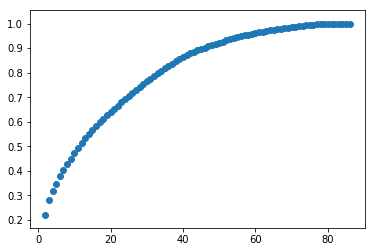

In [40]:
# Investigate the variance accounted for by each principal component.

n_comp = list(range(2,87))
plt.scatter(n_comp,explained_variance)

In [41]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12,rotation=45)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

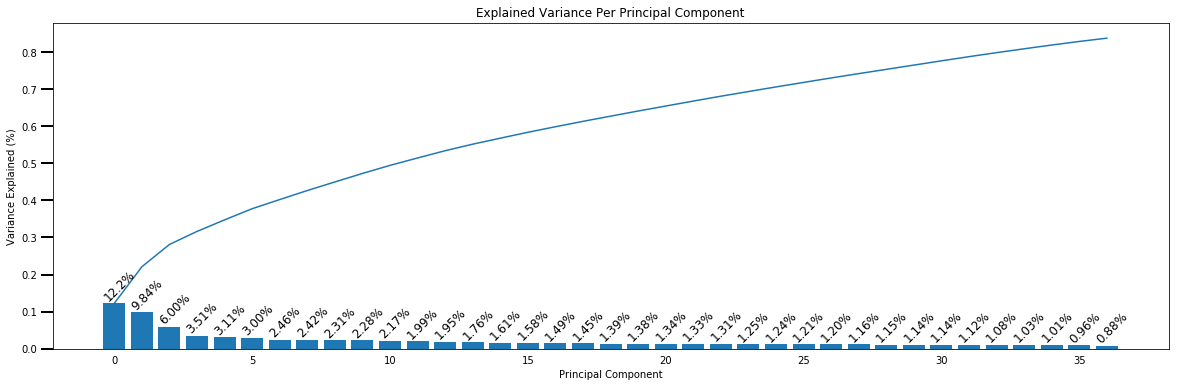

In [42]:
# Re-apply PCA to the data while selecting for number of components to retain.

comp = 37
pca = PCA(comp)
general_dataset_pca = pca.fit_transform(std_data)
#pca, general_dataset_pca = do_pca(comp,std_data)

scree_plot(pca)

### Discussion 2.2: Perform Dimensionality Reduction

Currently there are 87 features in the encoded dataset. The principal component analysis on the data has been done for a range of 87 components and its explained variance ratio has been calculated. Based on the trend plotted in the first figure, I am going to consider 0.85 as a cut off variance for the anaylsis. The number of componenets that captures 0.85 variance is 37. Reapplied PCA to the data again to create 37 latent features and generated scree plot which displays individual component's variance ratio.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [43]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def weights_per_features(full_dataset, pca, comp_no):
    '''
    Calculate weights per features for a specific principal component
    '''
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    component_df = pd.DataFrame(components.iloc[comp_no])
    sorted_comp = component_df.sort_values(comp_no,ascending=False)
    print("Top 10 positive weight features of component {}".format(comp_no))
    print(sorted_comp[:10])
    print("\nTop 10 negative weight features of component {}".format(comp_no))
    print(sorted_comp[-10:])
    
weights_per_features(encoded_dataset, pca, 0)

Top 10 positive weight features of component 0
                         0
PLZ8_ANTG3          0.2300
PLZ8_ANTG4          0.2232
WEALTH              0.2055
ORTSGR_KLS9         0.2024
HH_EINKOMMEN_SCORE  0.2005
EWDICHTE            0.1999
FINANZ_HAUSBAUER    0.1627
PLZ8_ANTG2          0.1555
KBA05_ANTG4         0.1541
ARBEIT              0.1481

Top 10 negative weight features of component 0
                        0
LIFESTAGE         -0.1220
BALLRAUM          -0.1308
INNENSTADT        -0.1689
PLZ8_GBZ          -0.1704
KONSUMNAEHE       -0.1705
FINANZ_MINIMALIST -0.2174
KBA05_GBZ         -0.2178
KBA05_ANTG1       -0.2260
PLZ8_ANTG1        -0.2295
MOBI_REGIO        -0.2427


In [44]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

weights_per_features(encoded_dataset, pca, 1)

Top 10 positive weight features of component 1
                           1
ALTERSKATEGORIE_GROB  0.2659
FINANZ_VORSORGER      0.2386
SEMIO_ERL             0.2200
SEMIO_LUST            0.1876
RETOURTYP_BK_S        0.1698
W_KEIT_KIND_HH        0.1249
FINANZ_HAUSBAUER      0.1143
SEMIO_KRIT            0.0982
PLZ8_ANTG3            0.0935
EWDICHTE              0.0917

Top 10 negative weight features of component 1
                            1
SEMIO_FAM             -0.1689
SEMIO_RAT             -0.1847
SEMIO_KULT            -0.2050
FINANZ_ANLEGER        -0.2156
FINANZ_UNAUFFAELLIGER -0.2340
SEMIO_PFLICHT         -0.2340
SEMIO_TRADV           -0.2369
FINANZ_SPARER         -0.2425
SEMIO_REL             -0.2511
DECADE                -0.2583


In [45]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

weights_per_features(encoded_dataset, pca, 2)

Top 10 positive weight features of component 2
                        2
SEMIO_VERT         0.3759
SEMIO_SOZ          0.2935
SEMIO_FAM          0.2855
SEMIO_KULT         0.2708
FINANZ_MINIMALIST  0.1652
RETOURTYP_BK_S     0.1022
SEMIO_REL          0.1006
FINANZ_VORSORGER   0.0908
W_KEIT_KIND_HH     0.0888
SEMIO_MAT          0.0772

Top 10 negative weight features of component 2
                            2
SEMIO_PFLICHT         -0.0615
FINANZ_UNAUFFAELLIGER -0.0916
FINANZ_SPARER         -0.0983
DECADE                -0.0987
FINANZ_ANLEGER        -0.1845
SEMIO_ERL             -0.2099
SEMIO_RAT             -0.2150
SEMIO_KRIT            -0.3102
SEMIO_DOM             -0.3481
SEMIO_KAEM            -0.3712


### Discussion 2.3: Interpret Principal Components

Based on my observation, detailed investigation of first three components are as follows:

Postive values indicate which fields contribute the most to that component, whereas Negative values indicate the fields which are not part of it.

##### First component 
    - Includes people who are mostly from PLZ8 macro-cell features, home owners. It doesn't include people who have 1-2 family houses in the microcell, low financial interest, owns common building type within the microcell etc.

##### Second component 
    - Includes people who are home owners, be prepared, event-oriented, sensual-minded, critical-minded whereas it doesn't include people who are family minded,culture oriented, religious, rational, dutiful,tradional-minded, investor, inconspicuous and money saver.

##### Third component 
    - Includes people who are socially minded, family minded,culture oriented, dreamful, low financial interest and religious. It doesn't include people who are event-oriented, combative attitude, dominant-minded, critical-minded, rational, investor, inconspicuous and money saver.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [67]:
# Over a number of different cluster counts...

batch_size = (general_dataset_pca.shape[0]*10)//100
k_value = []
k_score = []
for i in range(1,15):
    
    mb_kmeans = MiniBatchKMeans(init ='k-means++', n_clusters = i, batch_size = batch_size, n_init = 10, 
                                max_no_improvement = 10, verbose = 0)
    
    # run k-means clustering on the data and...
    model = mb_kmeans.fit(general_dataset_pca)
    k_value.append(i)
    
    # compute the average within-cluster distances.
    k_score.append(abs(model.score(general_dataset_pca)))

print(k_score)

[57709297.806928545, 51432444.918854214, 48120599.889298089, 46285814.186893724, 45139463.044008873, 44308799.095133372, 44334163.959908247, 42277428.077323601, 43051829.148412868, 40785126.834133357, 40722715.586926542, 39826507.926887155, 38829940.181721598, 40306966.876718424]


([<matplotlib.axis.XTick at 0x7f3f8f4622e8>,
 <a list of 14 Text xticklabel objects>)

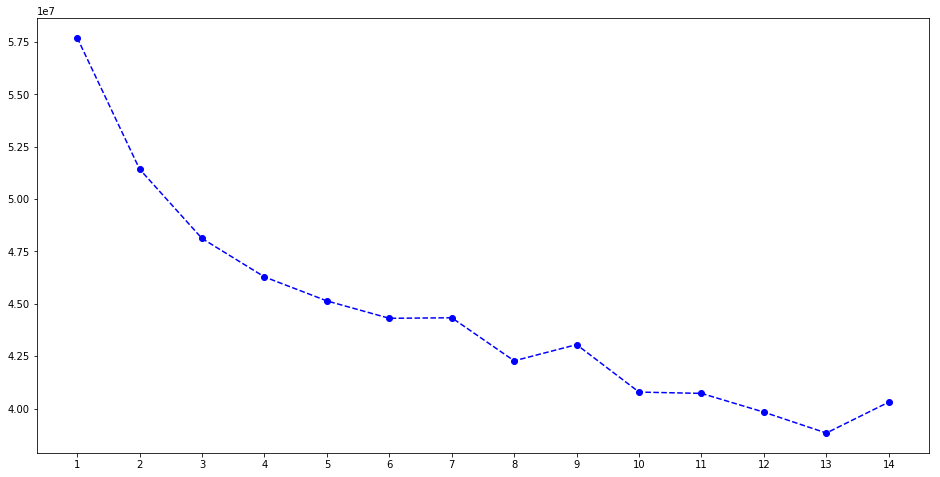

In [68]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.figure(figsize=(16,8))
plt.plot(k_value,k_score,linestyle='--',marker='o',color='b') 
plt.xticks(range(1,15))

In [69]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
  
def fit_kmeans(n_cluster, dataset_pca):
    """
    Fits and Predicts dataset using KMeans and the specified clusters.
    """
    k_means = KMeans(n_cluster)
    model = k_means.fit(dataset_pca)
    labels = model.predict(dataset_pca)
    cluster_centers = model.cluster_centers_
    return labels, cluster_centers
    
n_cluster = 8
labels,cluster_centers = fit_kmeans(n_cluster, general_dataset_pca)
print(cluster_centers)

[[ -1.44136083e+00  -3.92618804e+00  -6.63792962e-01   1.80569893e-01
   -7.08354172e-03   2.34399908e-02  -2.98730167e-02   1.76226932e-01
   -9.36579502e-02  -6.09220945e-02   1.24455990e-01  -1.27432156e-01
    1.41358894e-03  -1.18025448e-01   9.29542934e-04  -7.09446935e-02
    9.98590654e-02   6.54086622e-03  -2.55991601e-03  -1.00263237e-01
   -2.67362312e-03   2.00159803e-01   1.37700081e-02   1.24194238e-03
    1.50642522e-02  -7.30132558e-03   5.40817794e-03   3.65732727e-03
    2.92375275e-03   2.29159710e-03   1.54736900e-03  -4.01218351e-03
   -9.01536563e-02  -7.15732664e-04   1.19922525e-01  -8.79688839e-02
    3.35840311e-02]
 [  3.71011743e+00  -1.53240988e+00  -2.42661866e+00  -2.38696523e-01
    8.93539431e-05  -3.75207957e-02  -2.78490025e-02  -1.46319426e-01
   -1.09402735e-01  -4.62833512e-02  -2.46632122e-01  -2.75380757e-01
    9.55225648e-03  -2.23781158e-01   2.27362649e-02   1.25810294e-01
    2.78406101e-01   3.43309417e-03  -4.02964138e-03  -1.78634902e-01


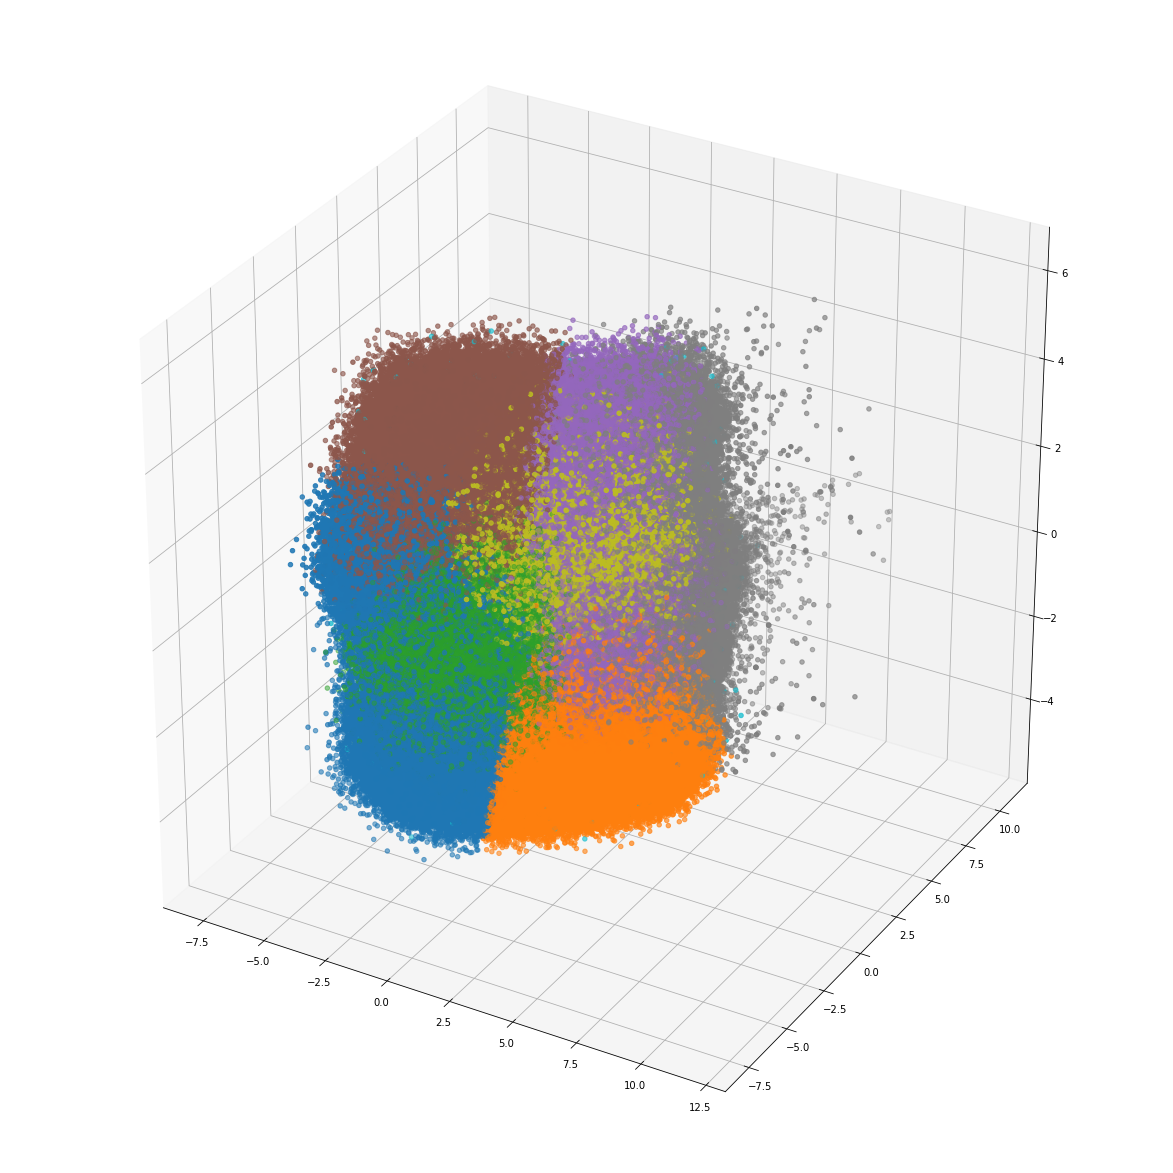

In [70]:
def plot_data(data, labels):
    '''
    Plot data with colors associated with labels
    '''
    fig = plt.figure(figsize=(16,16))
    ax = Axes3D(fig)
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=labels, cmap='tab10')
    
plot_data(general_dataset_pca, labels)

### Discussion 3.1: Apply Clustering to General Population

Due to the size of the dataset, MiniBatch KMeans clustering was used. It takes 10% of the dataset everytime it goes through the 'for' loop, creates kmeans object, calculates model's score for a range of clusters(15 clusters). Then the scores were plotted. Per the elbow method, we can see a drop at cluster number 8. Hence  re-fitted the k-means model using the full dataset and segmented population into 8 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [71]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv",delimiter=";")

Lets check the size of the data.

In [72]:
customers.shape

(191652, 85)

In [73]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

encoded_cust_dataset = clean_data(customers)

print("\n")
cust_imp_data = Imputer(missing_values='NaN', strategy='mean', axis=0).fit_transform(encoded_cust_dataset)
print("Imputation on the customer data has been completed.")

cust_std_data = StandardScaler().fit_transform(cust_imp_data)
print("Feature scaling has been completed.")

pca_cust, cust_dataset_pca = do_pca(comp,cust_std_data)
print("Dimensions of the customer data has been reduced using PCA.")
print("Size of the data after PCA: ", cust_dataset_pca.shape)

labels_cust, cluster_centers_cust = fit_kmeans(n_cluster, cust_dataset_pca)
print("Customer data has been clustered successfully.")

Outlier columns:  ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


Size of the dataset before dropping multi-level categoricals: (140898, 79) 
Size of the dataset after dropping multi-level categoricals: (140898, 68)
Column(s) that is/are removed: ['CJT_GESAMTTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


Size of the dataset before dropping OST_WEST_KZ: (140898, 68) 


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Size of the dataset after dropping OST_WEST_KZ: (140898, 67)
Column(s) that is/are removed: OST_WEST_KZ


Size of the dataset before dropping re-encoded columns: (140898, 67) 
Size of the dataset after dropping re-encoded columns: (140898, 61)
Column(s) that is/are removed: ['ANREDE_KZ', 'FINANZTYP', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'ZABEOTYP', 'GEBAEUDETYP']

Size of the dataset after Re-encoding:  (140898, 87)


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3798: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


Mixed type features:
['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']


Size of the dataset before dropping Mixed type features: (140898, 92) 
Size of the dataset after dropping Mixed type features: (140898, 86)
Column(s) that is/are removed: ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']


Imputation on the customer data has been completed.
Feature scaling has been completed.
Dimensions of the customer data has been reduced using PCA.
Size of the data after PCA:  (140898, 37)
Customer data has been clustered successfully.


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Lets use general population pca and customer pca to create its respective dataframes and merge its respective KMeans clustering labels. These two dataframes will be used later to create the plot.

In [74]:
cust_dataset_df = pd.DataFrame(cust_dataset_pca)
labels_cust_df = pd.DataFrame(list(labels_cust),columns = ['ClusterLabels'])
cust_dataset_df = cust_dataset_df.join(labels_cust_df['ClusterLabels'])
print("Size of the customer dataset: ",cust_dataset_df.shape)
cust_dataset_df.head()

Size of the customer dataset:  (140898, 38)


,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,ClusterLabels
0,-3.423818,-2.943212,1.819585,0.253258,-0.827705,2.655603,-0.335375,2.212721,1.112804,-1.427818,...,-0.033237,0.029360,-0.376732,0.255390,-1.537057,-0.256558,-0.376904,1.878126,0.201212,3
1,3.103009,-2.188157,-2.434968,-1.518293,-0.364935,-0.463487,-0.752731,-1.149280,-1.938910,1.523879,...,-1.751705,0.540424,4.480107,0.346387,-0.136806,-1.486339,-0.320585,-0.923135,-0.779468,7
2,-2.746384,-1.015065,-0.082079,3.253635,0.285730,0.693997,1.076766,-0.686733,-1.622698,1.236297,...,0.039245,-0.118596,-0.755661,-0.247267,-0.044563,0.041734,0.097748,-1.328897,0.022489,5
3,2.403353,4.374092,1.088803,2.010955,-2.312673,0.175969,-2.184118,-1.388140,1.335708,-0.108830,...,-1.515236,-0.527706,0.519759,0.467571,-2.329633,-0.582636,1.990412,-1.256194,0.366232,1
4,0.062062,-0.510520,1.554277,-0.835317,-2.537796,2.238860,-0.695317,-0.869137,0.819486,-1.329711,...,1.452160,1.472149,-0.348615,-0.998452,-0.505466,1.197417,-0.160145,0.148200,-1.095092,3


In [75]:
final_dataset_df = pd.DataFrame(general_dataset_pca)
labels_general_df = pd.DataFrame(list(labels),columns = ['ClusterLabels'])
final_dataset_df = final_dataset_df.join(labels_general_df['ClusterLabels'])
print("Size of the general population dataset: ",final_dataset_df.shape)
final_dataset_df.head()

Size of the general population dataset:  (792287, 38)


,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,ClusterLabels
0,3.792290,-2.864852,-2.551714,-0.144373,0.216066,-2.273797,2.214299,2.538524,0.835940,-2.837366,...,0.046748,-0.062652,-0.086969,-0.466826,-1.022623,0.822485,0.146048,0.812285,-1.134430,1
1,-0.740588,0.034357,-3.097996,-1.660298,-1.051768,-0.274672,1.350053,0.437208,-1.241402,1.491899,...,-0.032126,0.115699,0.272361,-0.487549,-0.132458,-0.512598,0.616832,-0.518266,0.720890,2
2,-3.996195,1.202527,-0.438740,0.296772,0.748101,-0.119487,-1.629706,-0.262720,0.302772,-0.253726,...,0.000117,-0.216766,-0.026082,-0.725320,-1.284708,-0.154187,-0.003216,-0.183894,0.112874,2
3,0.484860,0.463787,3.010700,-0.998556,-1.163983,0.704850,1.587831,-3.397917,-0.380388,-0.466053,...,0.062338,-0.145094,0.184328,0.865467,1.245554,0.693347,1.175731,-0.480190,1.251919,3
4,-0.881336,-1.540462,-0.548725,0.524069,-1.056132,-3.661501,0.663438,0.030873,0.641417,-1.711006,...,-0.002994,-0.490893,0.206495,-0.156217,-0.149801,-1.080807,-0.624792,-0.575989,0.209178,0


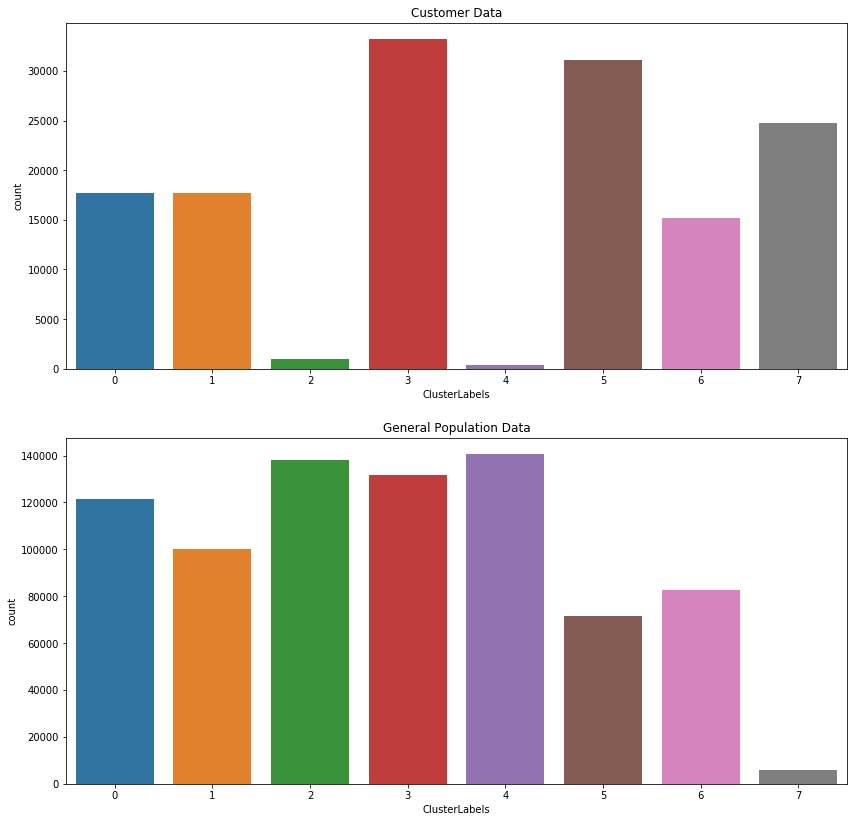

In [76]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

plt.figure(figsize=(14,14))
plt.subplot(2,1,1)
plt.title("Customer Data")
sns.countplot(x='ClusterLabels',data=cust_dataset_df)
plt.subplot(2,1,2)
plt.title("General Population Data")
sns.countplot(x='ClusterLabels',data=final_dataset_df)

Lets calculate ratio for both customer and general population clusters and their differences for our analysis.

In [77]:
cust_total = cust_dataset_df.shape[0]
cust_ratio = cust_dataset_df['ClusterLabels'].reset_index().groupby('ClusterLabels').count()/cust_total*100
cust_ratio.columns = ['Customer_ratio']

general_total = final_dataset_df.shape[0]
general_ratio = final_dataset_df['ClusterLabels'].reset_index().groupby('ClusterLabels').count()/general_total*100
general_ratio.columns = ['GeneralPopulation_ratio']

cluster_comparison_df = cust_ratio
cluster_comparison_df = cluster_comparison_df.join(general_ratio)
cluster_comparison_df['Difference'] = cluster_comparison_df['Customer_ratio']- cluster_comparison_df['GeneralPopulation_ratio']
cluster_comparison_df.sort_values('Difference',inplace=True,ascending=False)
cluster_comparison_df.head(10)

,Customer_ratio,GeneralPopulation_ratio,Difference
ClusterLabels,,,
7,17.597127,0.742155,16.854972
5,22.054252,9.040916,13.013336
3,23.559596,16.618852,6.940745
6,10.745362,10.434603,0.310759
1,12.536729,12.663214,-0.126486
0,12.558021,15.329546,-2.771525
2,0.711862,17.437368,-16.725506
4,0.237051,17.733347,-17.496296


Lets use .inverse_transform() method transform centroids back to the original data space for our interpretation.

In [78]:
cluster_df = pd.DataFrame(std.inverse_transform(pca.inverse_transform(cluster_centers)),columns=encoded_dataset.columns)
cluster_df.head(10)

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,...,20,21,22,23,24,DECADE,MOVEMENT,NATION,WEALTH,LIFESTAGE
0,1.866181,2.860703,3.939225,2.250219,4.189110,3.917359,2.312294,2.219660,2.428949,4.231618,...,0.222883,0.001166,0.000004,0.000724,0.195022,5.624922,1.271069,2.698634,2.308993,3.193337
1,1.733235,1.238375,4.282687,2.198653,4.196032,3.773519,4.079378,2.190579,2.638447,3.235758,...,0.226729,0.000964,0.000010,0.000691,0.191121,5.593567,1.078701,2.686582,4.113540,2.261691
2,3.484615,3.817266,1.836619,4.072485,2.606422,2.152189,2.634679,2.151161,3.508915,2.668317,...,0.224582,0.001022,-0.000002,0.000824,0.192867,3.705416,1.369585,2.719572,2.310758,3.455647
3,3.477787,3.027180,1.832523,4.351775,1.895895,1.712886,3.944690,2.172616,4.293868,3.935121,...,0.223265,0.001165,0.000004,0.000829,0.192825,3.301805,1.100336,2.795538,4.134502,2.580173
4,3.284414,4.612261,1.597310,4.289406,1.827863,1.934760,2.140742,2.173710,3.939580,5.016819,...,0.222099,0.000949,-0.000002,0.000649,0.191551,3.505859,1.400043,2.680787,2.348254,3.367650
5,3.356757,2.544746,2.176579,4.033116,2.077715,1.774896,4.217762,2.176849,4.249453,4.154885,...,0.224409,0.001139,-0.000003,0.000725,0.190428,3.582778,1.061862,2.782304,4.542635,2.229659
6,1.899005,2.127810,4.250517,2.176636,3.488953,3.722990,3.388815,2.381024,2.898356,6.439308,...,0.225158,0.001324,-0.000001,0.000734,0.193258,5.617670,1.163287,2.680445,4.134923,2.201019
7,2.788143,3.044014,2.685715,3.452067,2.820348,2.640895,3.144514,2.178451,3.455426,4.130403,...,0.217405,0.000955,0.000002,0.000370,0.185323,4.315987,1.232223,2.721880,3.224586,2.851015


In [79]:
#What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
print(cluster_comparison_df.iloc[0])
cluster_df.iloc[7].sort_values(ascending=False)

Customer_ratio             17.597127
GeneralPopulation_ratio     0.742155
Difference                 16.854972
Name: 7, dtype: float64


MIN_GEBAEUDEJAHR         1993.149414
KBA13_ANZAHL_PKW          617.814086
ANZ_HAUSHALTE_AKTIV         8.386932
WOHNDAUER_2008              7.932075
ORTSGR_KLS9                 5.327114
SEMIO_ERL                   4.644856
INNENSTADT                  4.573177
SEMIO_KRIT                  4.544690
SEMIO_DOM                   4.534939
HH_EINKOMMEN_SCORE          4.457402
REGIOTYP                    4.446972
DECADE                      4.315987
SEMIO_KAEM                  4.299775
SEMIO_VERT                  4.291980
SEMIO_LUST                  4.285720
SEMIO_PFLICHT               4.181349
BALLRAUM                    4.180569
SEMIO_SOZ                   4.130403
W_KEIT_KIND_HH              4.121603
SEMIO_KULT                  4.114410
SEMIO_FAM                   4.094606
EWDICHTE                    3.959134
SEMIO_REL                   3.948843
SEMIO_RAT                   3.877346
SEMIO_MAT                   3.812578
SEMIO_TRADV                 3.733111
GEBAEUDETYP_RASTER          3.677742
P

In [82]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
print(cluster_comparison_df.iloc[7])
cluster_df.iloc[4].sort_values(ascending=False)

Customer_ratio              0.237051
GeneralPopulation_ratio    17.733347
Difference                -17.496296
Name: 4, dtype: float64


MIN_GEBAEUDEJAHR         1993.659960
KBA13_ANZAHL_PKW          682.013497
WOHNDAUER_2008              8.349670
SEMIO_VERT                  5.979524
INNENSTADT                  5.359144
SEMIO_SOZ                   5.016819
SEMIO_LUST                  4.932226
BALLRAUM                    4.806909
SEMIO_KULT                  4.796955
SEMIO_FAM                   4.741238
FINANZ_MINIMALIST           4.612261
FINANZ_VORSORGER            4.289406
SEMIO_ERL                   4.269858
W_KEIT_KIND_HH              4.265853
ORTSGR_KLS9                 4.149152
REGIOTYP                    4.102066
KBA05_GBZ                   4.041839
MOBI_REGIO                  4.012460
GEBAEUDETYP_RASTER          3.993364
RETOURTYP_BK_S              3.939580
PLZ8_GBZ                    3.866703
KONSUMNAEHE                 3.704611
SEMIO_MAT                   3.694724
SEMIO_REL                   3.690376
DECADE                      3.505859
SEMIO_KRIT                  3.498204
PLZ8_HHZ                    3.490054
L

### Discussion 3.3: Compare Customer Data to Demographics Data

Per the analysis, we can conclude that **Cluster 7** is overrepresented in the custer data compared to the general population.
        
        Customer_ratio             17.597127
        GeneralPopulation_ratio     0.742155
        Difference                 16.854972
        
This suggests that the people in cluster 7 to be a target audience for the company. Lets examine cluster 7 further.
    It includes people who : 
    * owns cars, 
    * lives in their residence for 6-7 years, 
    * lives in community of 20,001 to  50,000 inhabitants, 
    * event-oriented - average affinity 
    * critical-minded - average affinity
    * dominant-minded - average affinity
    * lives 5 - 10 km to city center(downtown), 
    * financially prepared - average
    * middle class
    * average income
    * decade - 70s
    * likelihood of children in household - average
    * incentive-receptive Normal-Returner
    * number of households within the PLZ8 region - 300-599 households
    * ratio of residential to commercial activity - mixed cell with middle business share
    etc
    
 
Similarly, we can conclude that **Cluster 4** is overrepresented in the custer data compared to the general population.
        
        Customer_ratio              0.712572
        GeneralPopulation_ratio    13.565917
        Difference                -12.853345
        
This suggests that the people in cluster 4 are group of persons to be outside of the target demographics. Lets see cluster 4 further.
    It includes people who :
    * lives in their residence for 7-10 years
    * not so rational,
    * decade - 60s,
    * lives 10 - 20 km to city center(downtown),
    * average investor
    * lives in a community of 10,001 to  20,000 inhabitants
    * high income
    * middle class
    * low financial interest
    * ratio of residential to commercial activity - mixed cell with low business share
    * conservative Low-Returner
    etc

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.

In [81]:
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook Identify_Customer_Segments.ipynb to html',
 '[NbConvertApp] Writing 1497561 bytes to Identify_Customer_Segments.html']